In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

# import classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from hyperopt import hp, fmin, tpe, space_eval
from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing

from tqdm import tqdm

%matplotlib inline
plt.style.use("ggplot")

In [2]:
train = pd.read_csv(r'data/train.csv', index_col='id')
test = pd.read_csv(r'data/test.csv', index_col='id')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float64
 18  Status       

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5271 entries, 7905 to 13175
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5271 non-null   int64  
 1   Drug           5271 non-null   object 
 2   Age            5271 non-null   int64  
 3   Sex            5271 non-null   object 
 4   Ascites        5271 non-null   object 
 5   Hepatomegaly   5271 non-null   object 
 6   Spiders        5271 non-null   object 
 7   Edema          5271 non-null   object 
 8   Bilirubin      5271 non-null   float64
 9   Cholesterol    5271 non-null   float64
 10  Albumin        5271 non-null   float64
 11  Copper         5271 non-null   float64
 12  Alk_Phos       5271 non-null   float64
 13  SGOT           5271 non-null   float64
 14  Tryglicerides  5271 non-null   float64
 15  Platelets      5271 non-null   float64
 16  Prothrombin    5271 non-null   float64
 17  Stage          5271 non-null   float64
dtypes: float6

In [5]:
# set stage type as object
train['Stage'] = train['Stage'].astype(object)

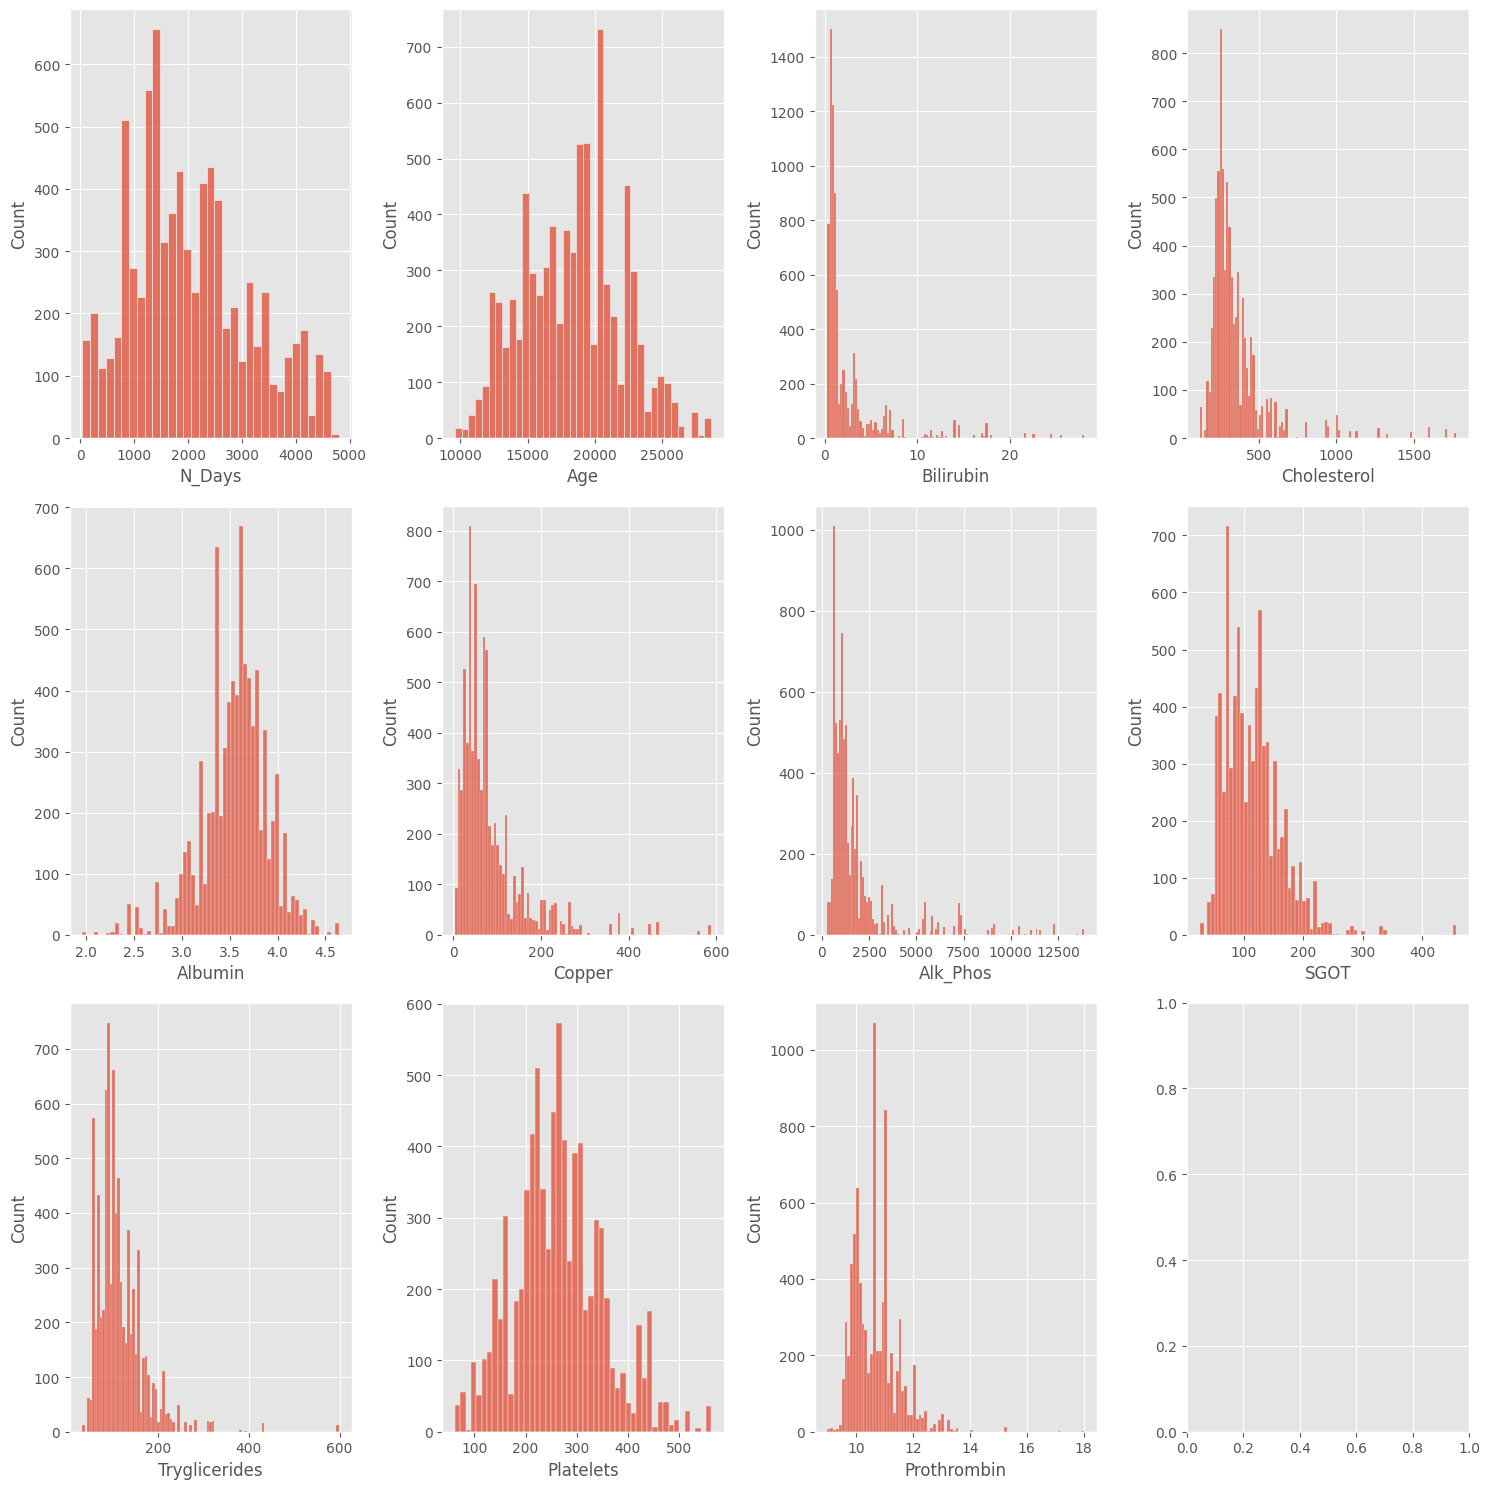

In [6]:
# vis numeric cols' distributions
dtypes = ['float64', 'int64']
float_data = train.select_dtypes(include=dtypes)
#float_data = float_data.drop('Stage', axis=1)

fig, ax = plt.subplots(3, 4, figsize=(15,15))
ax = ax.flatten()

for index, col in enumerate(float_data.columns):
    sns.histplot(float_data[col], ax=ax[index])
    #ax[index].set_title(f"{col}")
    
plt.tight_layout()
plt.show()

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   object 
 18  Status       

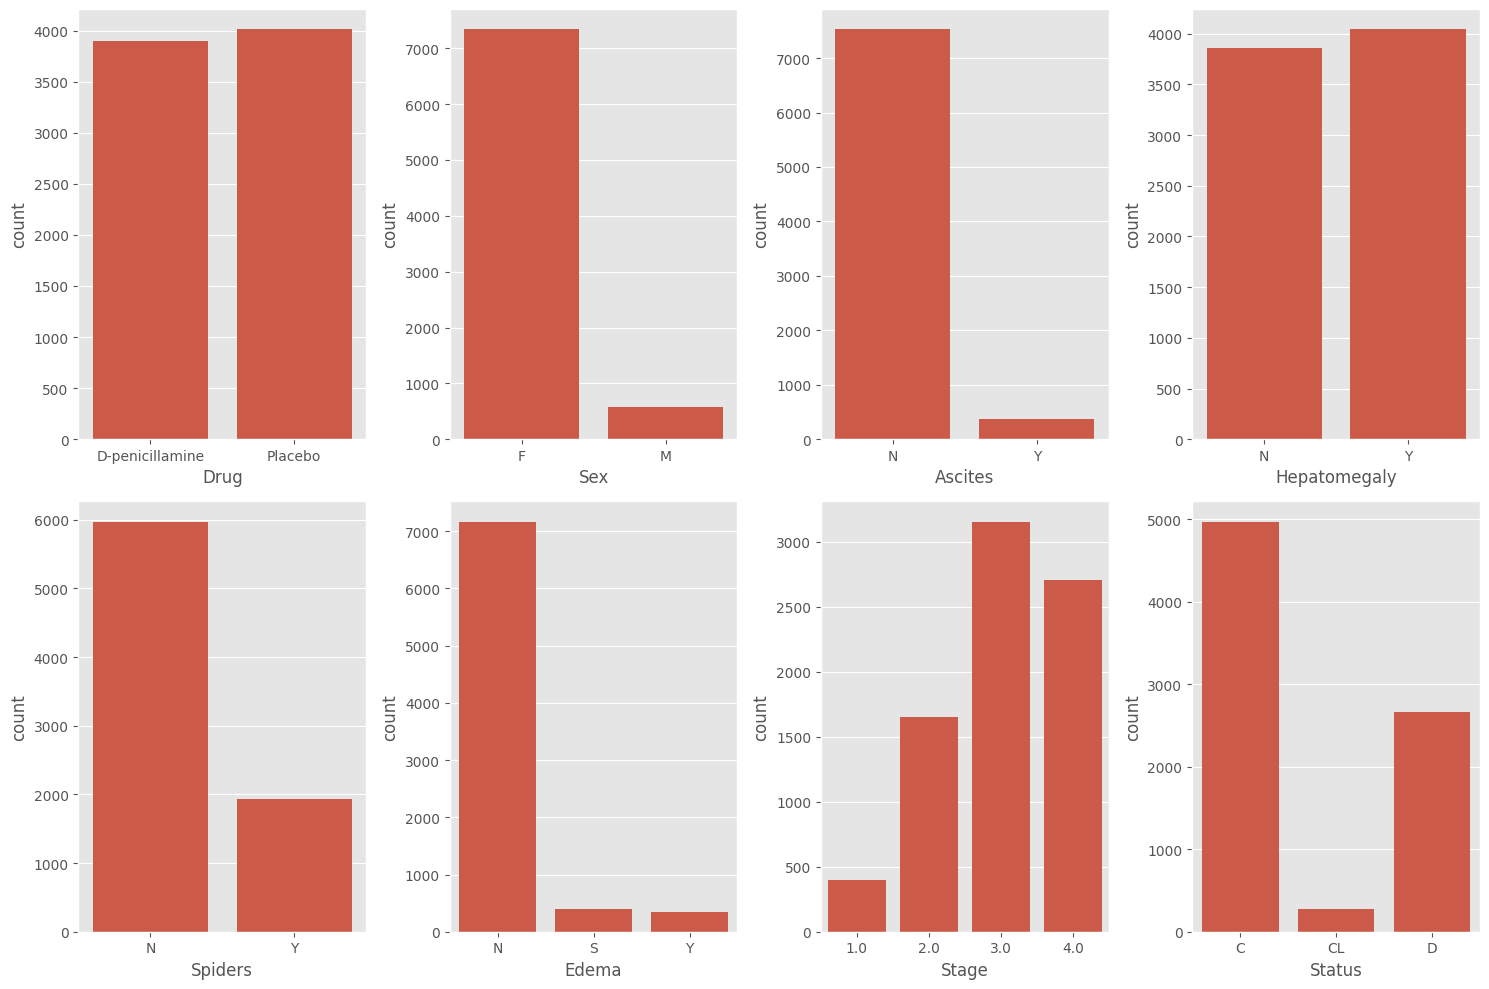

In [8]:
dtypes2 = ['object']
cat_data = train.select_dtypes(include=dtypes2)
cat_data['Stage'] = train['Stage']
cat_data = cat_data.astype('category')

fig, ax = plt.subplots(2, 4, figsize=(15,10))
ax = ax.flatten()

for index, col in enumerate(cat_data):
    sns.countplot(data=cat_data, x=col, ax=ax[index])
    
plt.tight_layout()
plt.show()

<Axes: xlabel='Status', ylabel='count'>

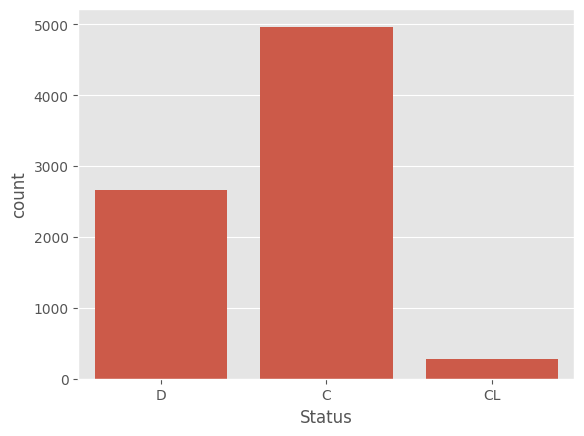

In [9]:
sns.countplot(data=train, x='Status')

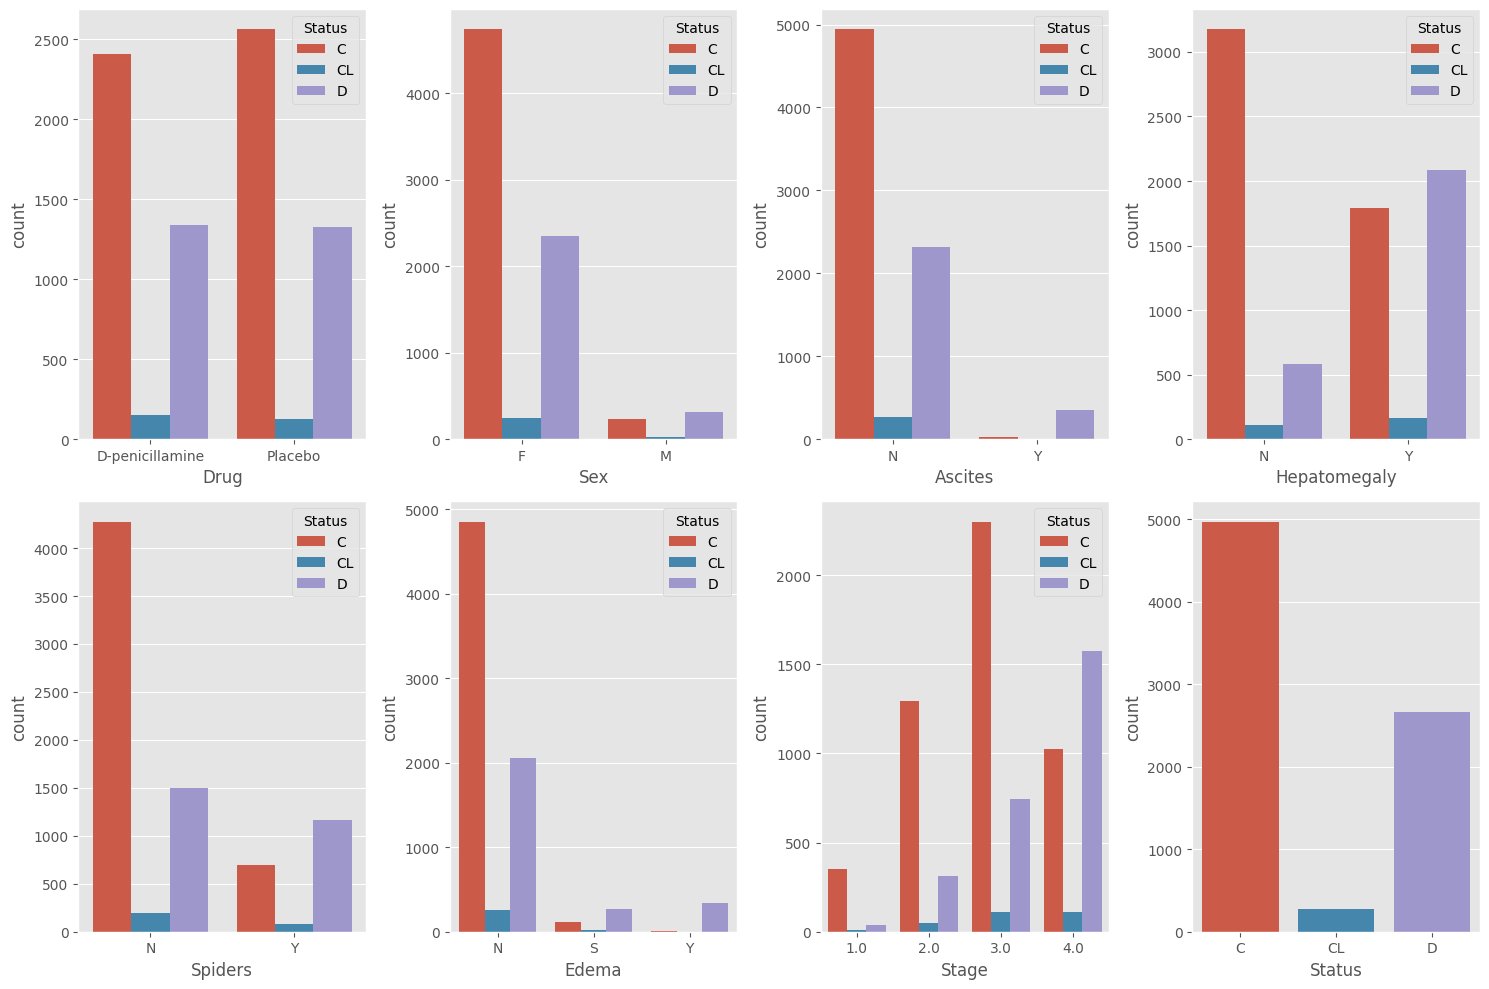

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(15,10))
ax = ax.flatten()
cat_data2 = cat_data.copy()
cat_data2['Status'] = cat_data['Status']

for index, col in enumerate(cat_data2):
    sns.countplot(data=cat_data2, x=col, hue='Status', ax=ax[index])

plt.tight_layout()
plt.show()


In [11]:
binary_cols = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders']
multi_cat_cols = ['Edema', 'Stage']

In [12]:
binary_data = pd.get_dummies(train[binary_cols], drop_first=True)
multi_cat_data = pd.get_dummies(train[multi_cat_cols])
int_data = train.select_dtypes(include=['int64'])

Text(0.5, 1.0, 'Correlations between numeric variables')

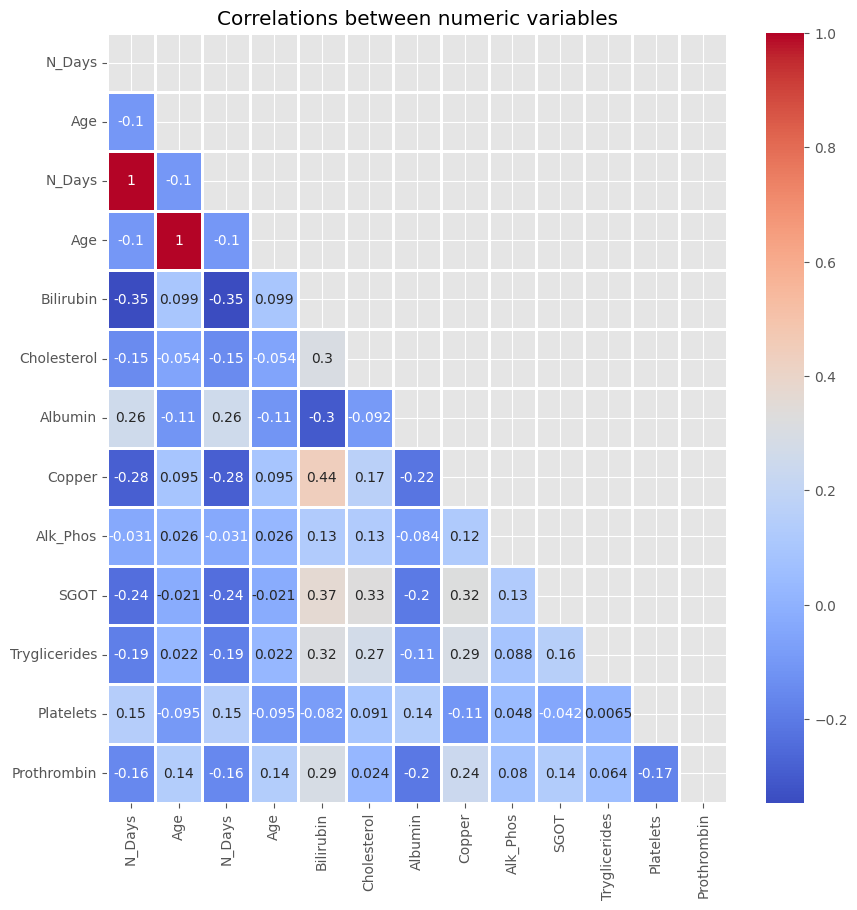

In [13]:
numeric_data = pd.concat([int_data, float_data], axis=1)
corr = numeric_data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=2, mask=mask)
plt.title("Correlations between numeric variables")

___

In [14]:
models = [RandomForestClassifier(), GradientBoostingClassifier(), LogisticRegression(max_iter=100),
          KNeighborsClassifier(), SVC(probability=True, max_iter=1000), DecisionTreeClassifier(), GaussianNB(),
          MLPClassifier(), AdaBoostClassifier(), XGBClassifier(num_class=3), LGBMClassifier()
         ]

In [15]:
X = pd.concat([binary_data, multi_cat_data, int_data, float_data], axis=1)
# drop duplicate columns
X = X.loc[:,~X.columns.duplicated()].copy()
y = train['Status']
# transform labels to numbers
y = LabelEncoder().fit_transform(y)

split = int(X.shape[0] * 0.8)
X_train, X_val = X.iloc[:split, :], X.iloc[split:, :]
y_train, y_val = y[:split], y[split:]

In [16]:
import warnings
warnings.filterwarnings("ignore")

def train_and_validate_models(models: list):
    train_losses = []
    val_losses = []

    for model in models: 
        #print(f"Current model: {model.__class__.__name__}")
        # fir model with train data
        model.fit(X_train, y_train)
        # predict on train
        y_pred_train = model.predict_proba(X_train)
        train_loss = log_loss(y_train, y_pred_train)
        train_losses.append(train_loss)

        #predict on validation data
        y_pred_val = model.predict_proba(X_val)
        val_loss = log_loss(y_val, y_pred_val)
        val_losses.append(val_loss)
        #print(f"train loss: {train_loss}\nval loss: {val_loss}")
    
    return train_losses, val_losses

train_losses, val_losses = train_and_validate_models(models)

Current model: RandomForestClassifier
train loss: 0.11514498646844863
val loss: 0.49656991903909653
Current model: GradientBoostingClassifier
train loss: 0.3616450429367864
val loss: 0.4459795475889635
Current model: LogisticRegression
train loss: 0.6246924458222564
val loss: 0.6265982414843644
Current model: KNeighborsClassifier


c:\Users\maciej.golik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train loss: 0.3867641188235074
val loss: 2.939946620604617
Current model: SVC


c:\Users\maciej.golik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


train loss: 1.1907050722477115
val loss: 1.1714027323277834
Current model: DecisionTreeClassifier
train loss: 4.440892098500627e-16
val loss: 9.506770058989154
Current model: GaussianNB
train loss: 1.7356293510315404
val loss: 1.6008764874532604
Current model: MLPClassifier


c:\Users\maciej.golik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\maciej.golik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


train loss: 7.146789619261177
val loss: 6.959496734103097
Current model: AdaBoostClassifier
train loss: 1.0519597859653627
val loss: 1.0525294432775998
Current model: XGBClassifier
train loss: 0.06288785762964892
val loss: 0.5086042470853733
Current model: LGBMClassifier
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1933
[LightGBM] [Info] Number of data points in the train set: 6324, number of used features: 23
[LightGBM] [Info] Start training from score -0.462317
[LightGBM] [Info] Start training from score -3.344935
[LightGBM] [Info] Start training from score -1.093880
train loss: 0.14843410823494482
val loss: 0.4564783525964209


In [17]:
def visualize_loss(loss, models, title="Models' Losses", ax=None):
    
    #fig = plt.figure(figsize=figsize)
    
    names = [model.__class__.__name__ for model in models]
    loss_dict = dict(zip(names, loss))
    sorted_losses = dict(sorted(loss_dict.items(), key=lambda item: item[1]))

    sns.barplot(y=sorted_losses.keys(), x=sorted_losses.values(), ax=ax, orient='h')
    ax.set_title(title)

    # Display values near the bars
    for i, (bar, value) in enumerate(zip(ax.patches, sorted_losses.values())):
        ax.annotate(f"{value:.2f}", (value, bar.get_y() + bar.get_height() / 2), ha='left', va='center')

    #plt.title(title)
    #plt.tight_layout()
    #plt.show()

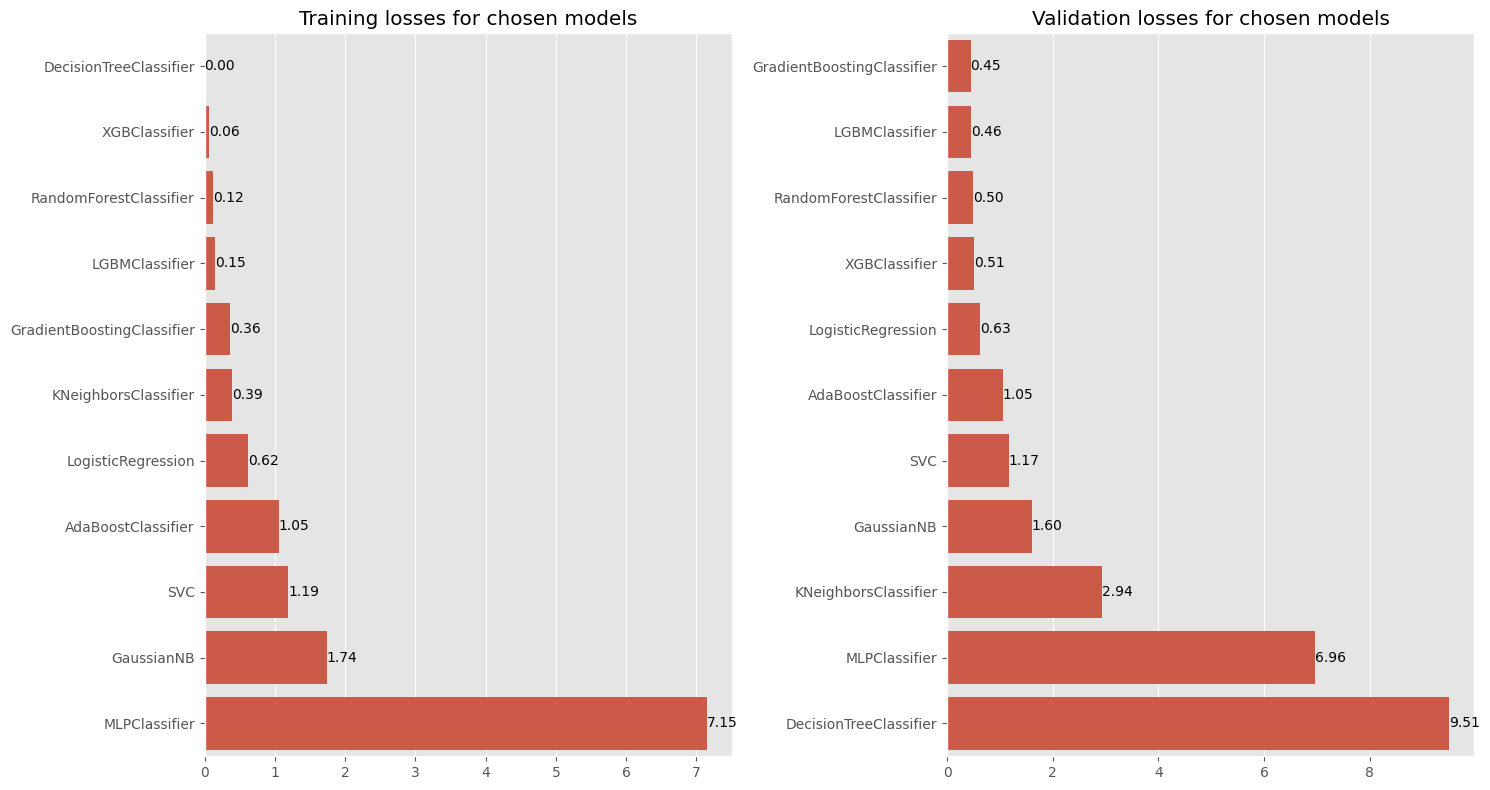

In [18]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
visualize_loss(train_losses, models, title='Training losses for chosen models', ax=ax[0])
visualize_loss(val_losses, models, title='Validation losses for chosen models', ax=ax[1])

plt.tight_layout()

#### Models with Scaling Data

In [19]:
def train_val_split(data, train_size=0.8, target_col='Status'):
    split = int(data.shape[0]*train_size)
    X_train, X_val = data[:split, :-1], data[split:, :-1]
    y_train, y_val = data[:split, -1], data[split:, -1]
    return X_train, y_train, X_val, y_val

In [20]:
numeric_features = train.select_dtypes(include=['float64', 'int64']).columns.to_list()
categorical_features = train.drop('Status', axis=1).select_dtypes(include=['object']).columns.to_list()
target = ['Status']

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", StandardScaler(), numeric_features),
        ("categorical", OneHotEncoder(), categorical_features)
    ]
)

target_encoded = LabelEncoder().fit_transform(np.array(train[target]).ravel())
data_pre = preprocessor.fit_transform(train)

split = 0.8
cut = int(split * train.shape[0])
X_train, X_val = data_pre[:cut, :], data_pre[cut:, :]
y_train, y_val = target_encoded[:cut], target_encoded[cut:]

train_losses, val_losses = train_and_validate_models(models)

Current model: RandomForestClassifier
train loss: 0.11428851596112513
val loss: 0.4810559117821609
Current model: GradientBoostingClassifier
train loss: 0.3616450429367864
val loss: 0.4457827556759163
Current model: LogisticRegression
train loss: 0.51866183821664
val loss: 0.5245213641778934
Current model: KNeighborsClassifier
train loss: 0.33218186484141826
val loss: 2.447169133909191
Current model: SVC


c:\Users\maciej.golik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\maciej.golik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


train loss: 0.4619739866872924
val loss: 0.5239901239075917
Current model: DecisionTreeClassifier
train loss: 4.440892098500627e-16
val loss: 9.757548166060811
Current model: GaussianNB
train loss: 2.4818706261599726
val loss: 2.404039690058835
Current model: MLPClassifier


c:\Users\maciej.golik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\maciej.golik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\maciej.golik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


train loss: 0.31910824511384767
val loss: 0.5678724638649758
Current model: AdaBoostClassifier
train loss: 1.0519597859653627
val loss: 1.0525294432775996
Current model: XGBClassifier
train loss: 0.06324801760409009
val loss: 0.5055782388703323
Current model: LGBMClassifier
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 6324, number of used features: 28
[LightGBM] [Info] Start training from score -0.462317
[LightGBM] [Info] Start training from score -3.344935
[LightGBM] [Info] Start training from score -1.093880
train loss: 0.15023095903750827
val loss: 0.47131125499643267


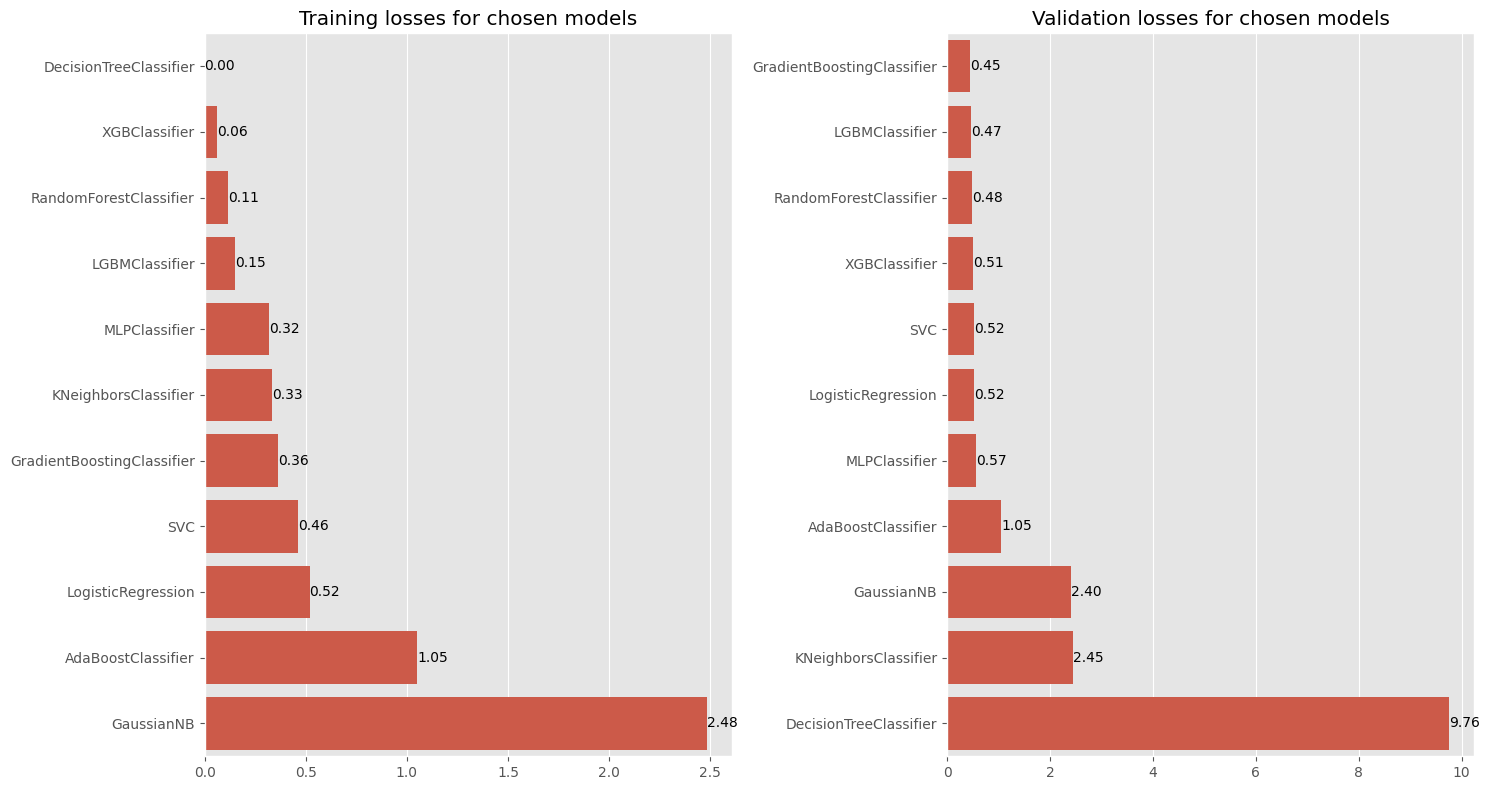

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
visualize_loss(train_losses, models, title='Training losses for chosen models', ax=ax[0])
visualize_loss(val_losses, models, title='Validation losses for chosen models', ax=ax[1])

plt.tight_layout()

### Optimize

In [29]:
X = pd.concat([binary_data, multi_cat_data, int_data, float_data], axis=1)
# drop duplicate columns
X = X.loc[:,~X.columns.duplicated()].copy()
y = train['Status']
# transform labels to numbers
y = LabelEncoder().fit_transform(y)

In [42]:
def optimize_model(model, X, y, param, space, split=0.8):

    #X = data.drop('Status', axis=1)
    #y = LabelEncoder().fit_transform(np.array(data['Status']).ravel())
    #data_pre = preprocessor.fit_transform(data)

    cut = int(split * train.shape[0])
    X_train, X_val = X.iloc[:cut, :], X.iloc[cut:, :]
    y_train, y_val = y[:cut], y[cut:]

    training_history = []
    validation_history = []
    parameter_vals = []

    for _, config in tqdm(enumerate(space)):
        # set params
        param_dict = {param: config}
        model.set_params(**param_dict)
        # fit training data
        model.fit(X_train, y_train)
        # predict on training data
        y_pred_train = model.predict_proba(X_train)
        # calculate training loss
        training_loss = log_loss(y_train, y_pred_train)
        
        # predict on validation data
        y_pred_val = model.predict_proba(X_val)
        # calculate validation loss
        validation_loss = log_loss(y_val, y_pred_val)

        training_history.append(training_loss)
        validation_history.append(validation_loss)
        parameter_vals.append(config)

    # visualize the losses for different configutations
    plt.figure(figsize=(10,10))

    train_line = plt.plot(parameter_vals, training_history, c='b', label='training')
    val_line = plt.plot(parameter_vals, validation_history, c='r', label='validation')

    plt.title(f'Training/Validation Loss\nOptimized Parameter: {param}')    
    plt.legend(handles=[train_line, val_line])
    plt.tight_layout()
    plt.show()

    return training_history, validation_history, parameter_vals

In [ ]:
#lr_space = np.sort(10**np.random.uniform(-3, 0, 20))
# ne_space = 10**np.array([1,2,3,4,5])
# t_hist, v_his, _ = optimize_model(GradientBoostingClassifier(learning_rate=0.07), X, y, 'n_estimators', ne_space)

In [46]:
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier()

param_space = {
    'learning_rate': [0.0001, 0.001, 0.01, 1],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4], 
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(gb, param_space, cv=5, scoring='neg_log_loss', n_jobs=-1)

grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 1],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='neg_log_loss')

In [47]:
grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 200}

In [48]:
grid_search.best_score_

-0.4801934519942379

In [50]:
grid_search.best_estimator_.predict(X_val)

c:\Users\maciej.golik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 28 features, but GradientBoostingClassifier is expecting 23 features as input.